In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

In [2]:
%matplotlib inline

In [3]:
seed = 42
random.seed(seed)

In [4]:
import matplotlib.style as style
style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

In [5]:
style.use('tableau-colorblind10')

# Importing Files

In [6]:
data = pd.read_csv('patient.csv')

# Exploratory Data Analysis

In [7]:
data.drop('id', axis=1, inplace=True)

In [8]:
data.head()

,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,female,1984.0,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
1,male,1964.0,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
2,male,1966.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
3,male,1964.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
4,male,1987.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7513 entries, 0 to 7512
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sex               662 non-null    object 
 1   birth_year        649 non-null    float64
 2   country           7513 non-null   object 
 3   region            421 non-null    object 
 4   disease           28 non-null     float64
 5   group             82 non-null     object 
 6   infection_reason  144 non-null    object 
 7   infection_order   35 non-null     float64
 8   infected_by       70 non-null     float64
 9   contact_number    50 non-null     float64
 10  confirmed_date    7513 non-null   object 
 11  released_date     55 non-null     object 
 12  deceased_date     36 non-null     object 
 13  state             7513 non-null   object 
dtypes: float64(5), object(9)
memory usage: 821.9+ KB


In [10]:
data.describe()

,birth_year,disease,infection_order,infected_by,contact_number
count,649.000000,28.0,35.000000,70.000000,50.000000
mean,1973.959938,1.0,2.285714,379.000000,69.400000
std,17.423331,0.0,1.405272,540.247528,182.876338
min,1929.000000,1.0,1.000000,3.000000,0.000000
25%,1961.000000,1.0,1.000000,29.250000,3.000000
50%,1974.000000,1.0,2.000000,126.000000,15.500000
75%,1990.000000,1.0,3.000000,563.250000,44.500000
max,2018.000000,1.0,6.000000,2621.000000,1160.000000


In [11]:
# missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
disease,7485,0.996273
infection_order,7478,0.995341
deceased_date,7477,0.995208
contact_number,7463,0.993345
released_date,7458,0.992679
infected_by,7443,0.990683
group,7431,0.989086
infection_reason,7369,0.980833
region,7092,0.943964
birth_year,6864,0.913616


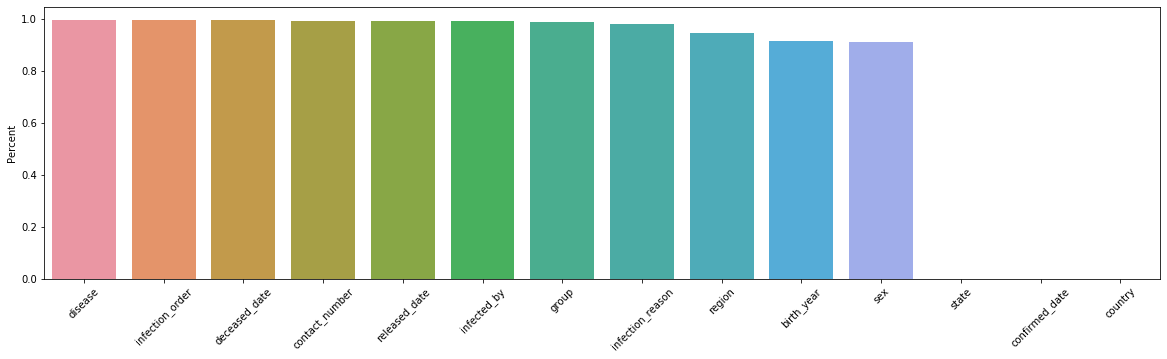

In [12]:
fig = plt.figure(figsize=(20, 5))
missing_plt = sns.barplot(x=missing_data.index, y=missing_data.Percent)
missing_plt.set_xticklabels(missing_plt.get_xticklabels(), rotation=45)
print()

It is clear that our dataset cointains huge amount of null values and we need to deal with it.<br>
99 to 93% data is missing in all the major features.

In [13]:
print([pd.value_counts(data[cols]) for cols in data.columns])

[female    385
male      277
Name: sex, dtype: int64, 1985.0    25
1995.0    22
1992.0    21
1962.0    18
1969.0    18
          ..
2015.0     1
1930.0     1
2007.0     1
1933.0     1
1939.0     1
Name: birth_year, Length: 80, dtype: int64, Korea       7504
China          8
Mongolia       1
Name: country, dtype: int64, capital area           191
Gyeongsangbuk-do       126
Daegu                   57
Daejeon                 13
Gwangju                 11
Gangwon-do               5
filtered at airport      4
Jeollanam-do             3
Jeollabuk-do             3
Chungcheongbuk-do        2
Ulsan                    2
Jeju-do                  2
Chungcheongnam-do        1
Busan                    1
Name: region, dtype: int64, 1.0    28
Name: disease, dtype: int64, Shincheonji Church               53
Eunpyeong St. Mary's Hospital    13
Cheongdo Daenam Hospital          9
Pilgrimage                        6
Myungsung church                  1
Name: group, dtype: int64, contact with patient       

<h2> Inputing Missing Values </h2>

Imputing missing values in a dataset is a laborious task some times it renders data useless. Here we will try to clean data 1 by 1.<br>
Generally it is recomended to drop rows containig more than 50% empty values but in this case removing those data will lead to shrinkage of dataset to point where it is not useable.
Firstly we will remove data that are not relevant or not very useful to us.<br>

<h4> Sex </h4>

In [14]:
print('No. of NA values in Sex:', data['sex'].isna().sum())

No. of NA values in Sex: 6851


Sex have most no. of data besides having 93% missing values, so we will start droping all other data where gender is missing.

In [15]:
data_cleaned = data.dropna(axis=0, subset=['sex'])

<h4>Birth_Year</h4>
<br>
    Birth year have some missing values and we will fill it up with mean.

In [16]:
data_cleaned['birth_year'].fillna(1973.0, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


<h4>Region</h4>
Region field has 18 missing field. Region field is not important for us if we want to make predictions but it will be useful for plotting data on map. For now we will remove region column.

In [17]:
data_cleaned = data_cleaned.drop('region', axis=1)

<h4>Disease</h4>
<br>
Disease column have null value where it patient does not have any disease, hence we will impute it with 0.0.

In [18]:
data_cleaned['disease'].fillna(0.0, inplace=True)

<h4>Group</h4>
<br>
Group would have been useful if had no missing values because it could have been treated as bins, but as of now it serves no purpose to us. Let's remove group.

In [19]:
data_cleaned = data_cleaned.drop('group', axis=1)

<h4>Infection Reason </h4>
Infection reason seems like an important categorical feature, we will simply impute reason as unknown where it is null in dataset.

In [20]:
data_cleaned['infection_reason'].fillna('Unknown', inplace=True)

<h4>Infection Order, Infected By, Contact Number, Released Date and Deceased Date</h4>
It contains very low amount of data it's better to get rid of these features.

In [21]:
data_cleaned = data_cleaned.drop(['infected_by','infection_order', 'contact_number', 'released_date', 'deceased_date'], axis=1)

In [22]:
data_cleaned.head()

,sex,birth_year,country,disease,infection_reason,confirmed_date,state
0,female,1984.0,China,0.0,visit to Wuhan,2020-01-20,released
1,male,1964.0,Korea,0.0,visit to Wuhan,2020-01-24,released
2,male,1966.0,Korea,0.0,visit to Wuhan,2020-01-26,released
3,male,1964.0,Korea,0.0,visit to Wuhan,2020-01-27,released
4,male,1987.0,Korea,0.0,visit to Wuhan,2020-01-30,released


In [23]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 662 entries, 0 to 7195
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sex               662 non-null    object 
 1   birth_year        662 non-null    float64
 2   country           662 non-null    object 
 3   disease           662 non-null    float64
 4   infection_reason  662 non-null    object 
 5   confirmed_date    662 non-null    object 
 6   state             662 non-null    object 
dtypes: float64(2), object(5)
memory usage: 41.4+ KB


<br>
By removing all the cluter and irrelevant data we are left with very samll but properly cleand dataset. Now we can analyze data, introduce new relevant features and make infrences about it. most of the data is categorical in nature.<br>
Let's get familiar with data.

# Data Visualization

<h3>Gender</h3>
Gender have only two column male and female we will analyze data on the basis of gender to understand effect of deadly corona virus on both males and females

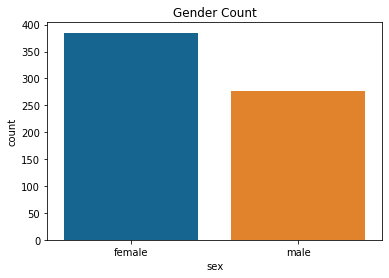

In [24]:
gender_count_plt = sns.countplot(data_cleaned['sex'], )
gender_count_plt.set_title('Gender Count')
plt.show()

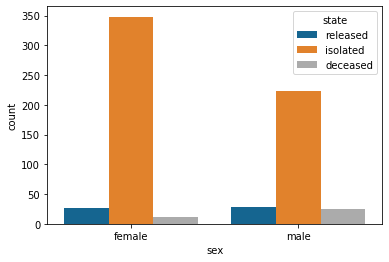

In [25]:
gender_vs_state_plt = sns.countplot(x='sex', hue='state', data=data_cleaned)
gender_count_plt.set_title('Gender VS State')
plt.show()

Above plots indidcates that both males and females got equally affected by the virus. With males slightly more than the females. Currently more females are kept isolated than men. Data also shows that although recovery in both males and females are almost identical but more males are deceased due to virus than compared to women.

<h3> Birth Year </h3>
<br>
Birth year will alow us to see which age group is more vulnerable to this deadly virus.

Let's add an age column to plot data easily.

In [26]:
data_cleaned['age'] = 2019 - data_cleaned['birth_year']
data_cleaned['age_bin'] = (data_cleaned['age'] // 10) * 10
data_cleaned = data_cleaned.drop('birth_year', axis=1)

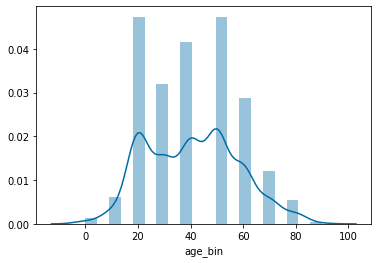

In [27]:
sns.distplot(data_cleaned['age_bin'])

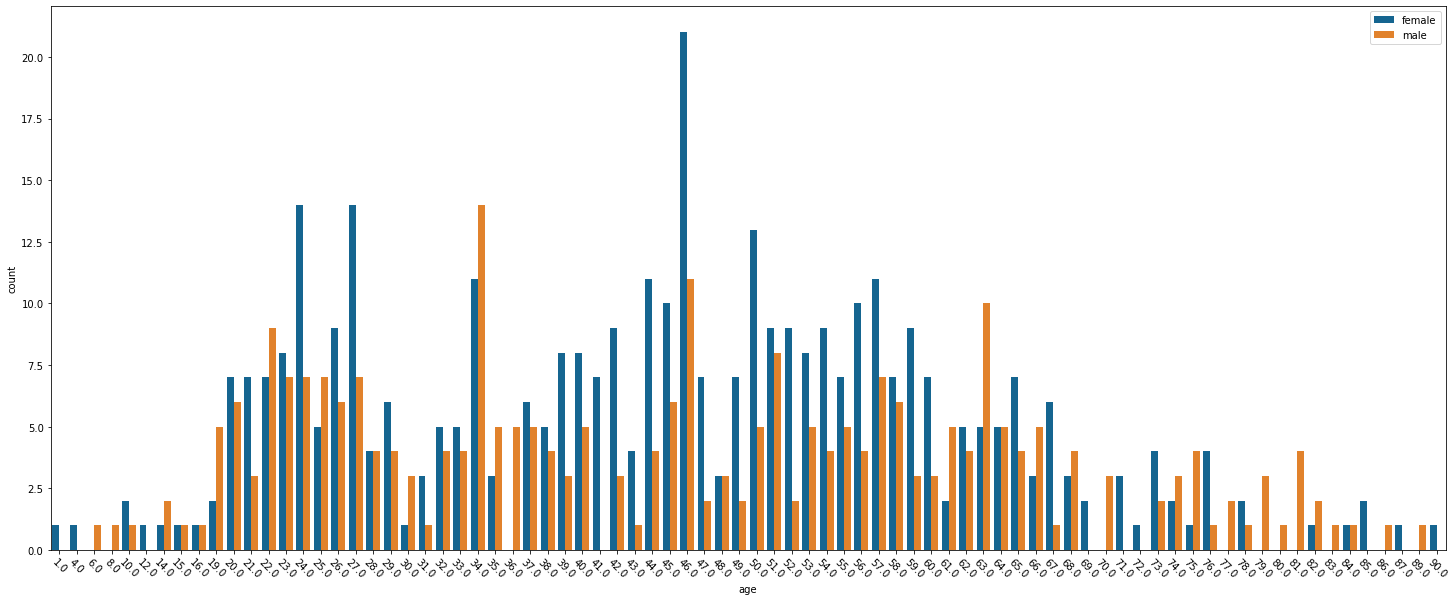

In [28]:
plt.figure(figsize=(25, 10))
age_sex_plt = sns.countplot(x='age', hue='sex', data=data_cleaned)
age_sex_plt.set_xticklabels(age_sex_plt.get_xticklabels(), rotation=-45)
age_sex_plt.legend(loc='upper right')

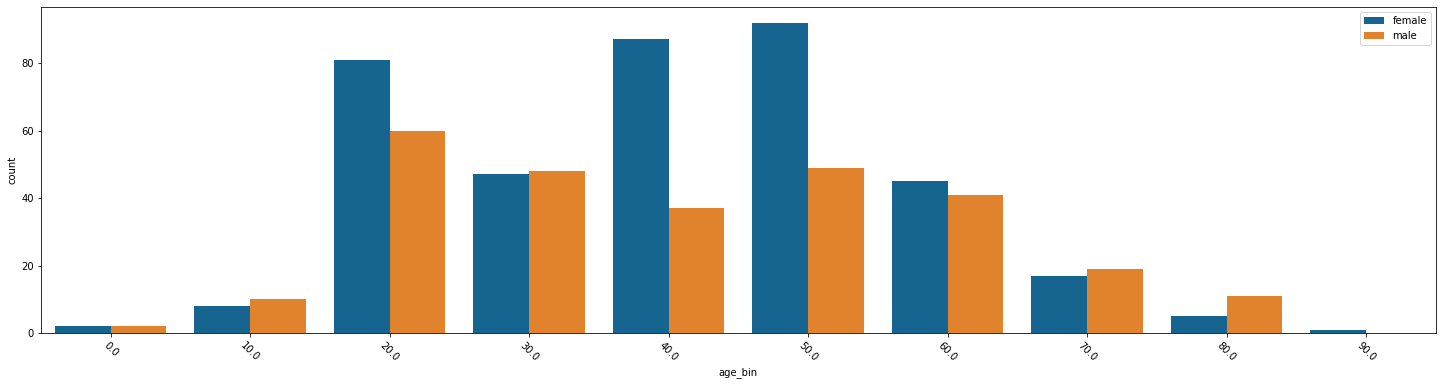

In [29]:
plt.figure(figsize=(25, 6))
age_sex_plt1 = sns.countplot(x='age_bin', hue='sex', data=data_cleaned)
age_sex_plt1.set_xticklabels(age_sex_plt1.get_xticklabels(), rotation=-45)
age_sex_plt1.legend(loc='upper right')


Text(0.5, 1.0, 'Age VS State')

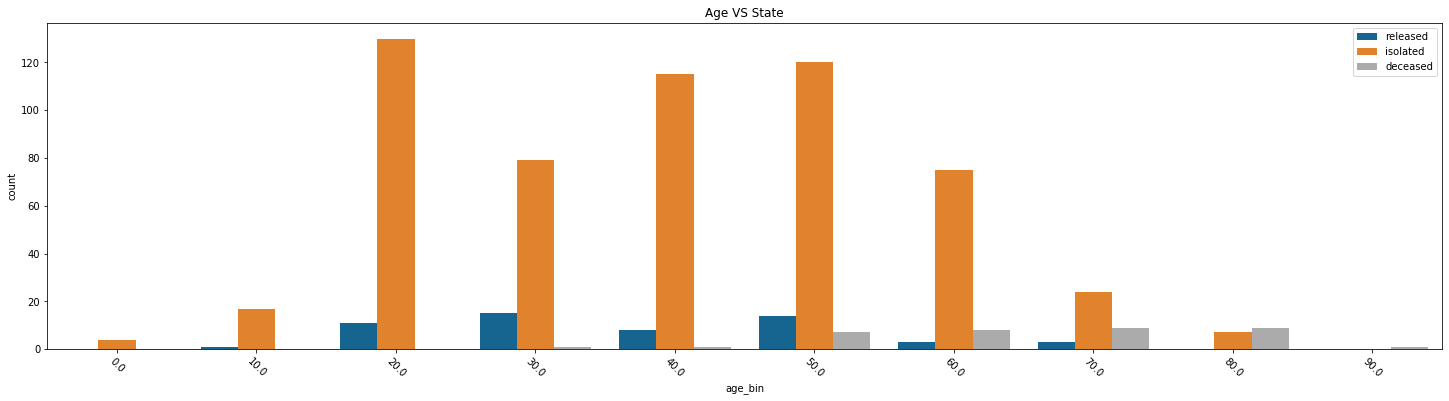

In [30]:
plt.figure(figsize=(25, 6))
age_state_plt = sns.countplot(x='age_bin', hue='state', data=data_cleaned)
age_state_plt.set_xticklabels(age_state_plt.get_xticklabels(), rotation=-45)
age_state_plt.legend(loc='upper right')
age_state_plt.set_title('Age VS State')

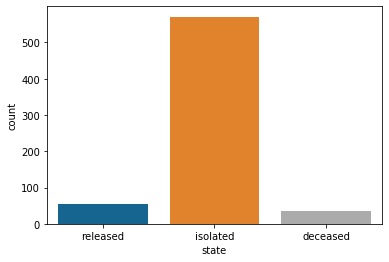

In [31]:
sns.countplot(data_cleaned['state'])

Most of the people infected by corona virus are in there 50's with higher females at higher risk than male, followed by 30's and 40's where male are more prone to risk in there 30's and female in there's 40.<br>
Older males are at higher risk whereas younger females are at higher risk of getting corona virus.<br>
Fatality in older age is quite higher there is gradual increase in mortatlity rate as age of patient increase. This shows that older people have lower chances of surviving.<br>
Till now most of the people are isolated it will be harder to predict state of patient as currently, only 55 people were released, 31 were dead and 344 are still isolated. Original data have much higher isolated values.<br>
Note: As dataset was not clean hence this data is not totally complete this infrences are only made on this dataset, It is assumed that this dataset represents overall trends on actual data.

<h3>Infection Reason</h3>
Infection reason seems like an interesting feature to explore.

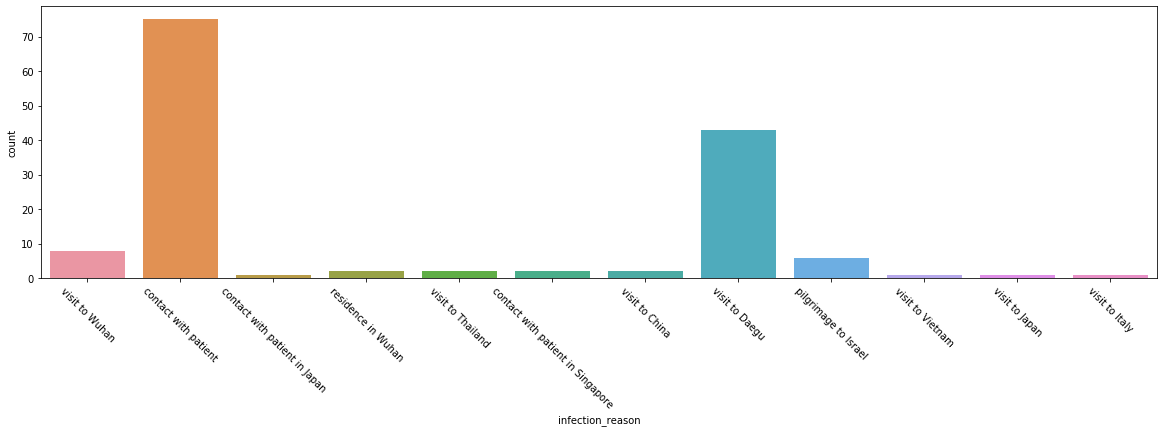

In [32]:
plt.figure(figsize=(20, 5))
infection_reason_plt = sns.countplot(data['infection_reason'])
infection_reason_plt.set_xticklabels(infection_reason_plt.get_xticklabels(), rotation=-45)
plt.show()

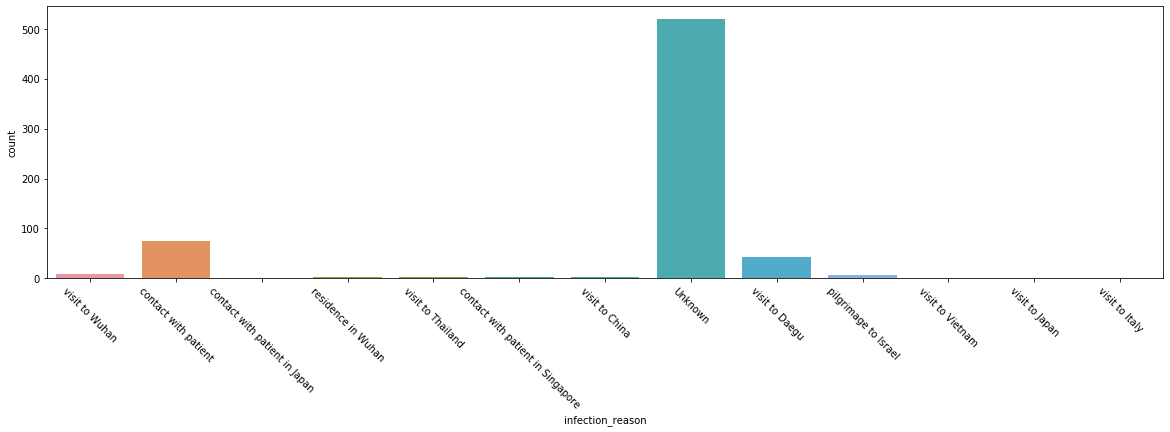

In [33]:
plt.figure(figsize=(20, 5))
infection_reason_plt1 = sns.countplot(data_cleaned['infection_reason'])
infection_reason_plt1.set_xticklabels(infection_reason_plt1.get_xticklabels(), rotation=-45)
plt.show()

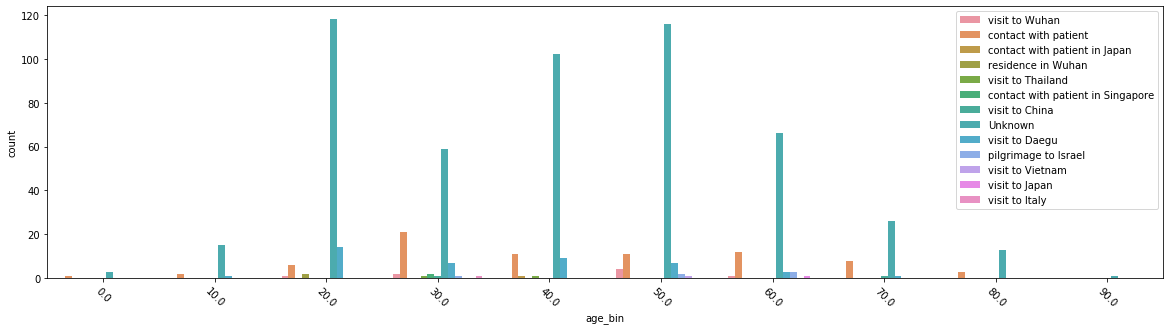

In [34]:
plt.figure(figsize=(20, 5))
reason_age_plt = sns.countplot(x='age_bin', hue='infection_reason', data=data_cleaned)
reason_age_plt.set_xticklabels(reason_age_plt.get_xticklabels(), rotation=-45)
reason_age_plt.legend(loc='upper right')
print()

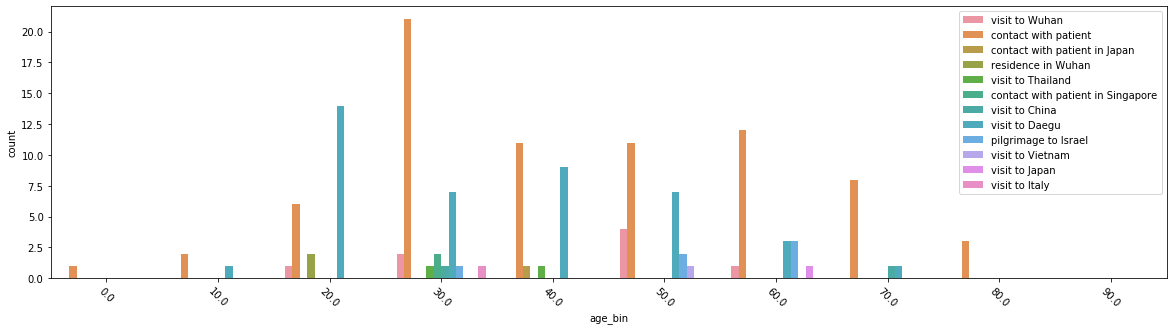

In [35]:
plt.figure(figsize=(20, 5))
reason_age_plt = sns.countplot(x=data_cleaned['age_bin'], hue=data['infection_reason'])
reason_age_plt.set_xticklabels(reason_age_plt.get_xticklabels(), rotation=-45)
reason_age_plt.legend(loc='upper right')
print()

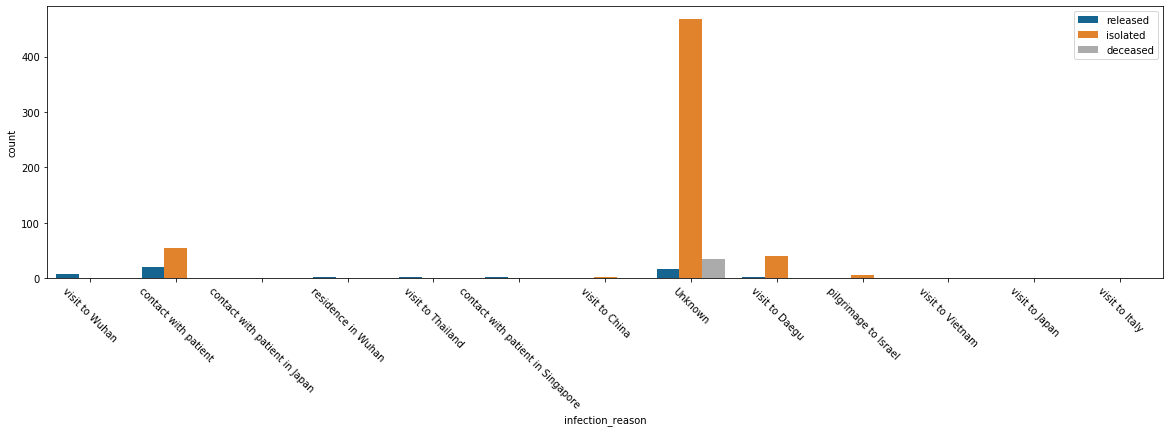

In [36]:
plt.figure(figsize=(20, 5))
reason_age_plt = sns.countplot(x=data_cleaned['infection_reason'], hue=data_cleaned['state'])
reason_age_plt.set_xticklabels(reason_age_plt.get_xticklabels(), rotation=-45)
reason_age_plt.legend(loc='upper right')
print()

Due to high unknown reason for a patient to get virus, plots got distorted so we will analyse data with and without unknow reason to better understand it.<br>
From above plot, Reason how patient got virus is mostly unknow for more than 275 patients.<br>
Apart from the unknown reason, patinets are mostly affected due to contact with another person. As this virus is highly contagious this seems like obvious reason. Another reasons includes visiting to places where virus is already spreading.
<br>
<br>
Getting infected due to pilgrimage is quite concerning as in Israel virus is not that prevalent yet <b> Pilgrimage have high risk</b> of spreading virus. <b> <br> We should definately avoid mass gathering. </b>

<h3>Disease</h3>
Underlying disease can be usefull to know effect of virus on patient with some underlying diseases.

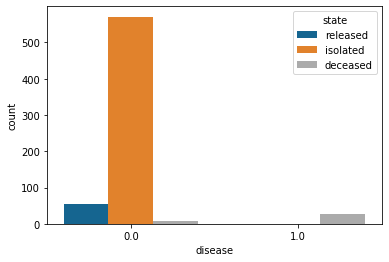

In [37]:
disease_vs_state_plt = sns.countplot(x='disease', hue='state', data=data_cleaned)

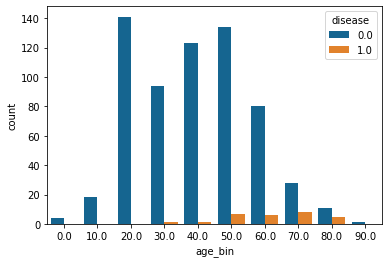

In [38]:
disease_vs_age_plt = sns.countplot(x='age_bin', hue='disease', data=data_cleaned)

Clearly as age increases underlying disease increases in population although this virus is not only isolated to person with underlying diseases but it definately increases risk for person dignosed with some past medical conditions. <br>
patients without underlying diseases have chances for recovering and released but patient with underlying conditions have negligible chance of surviving.

In [39]:
# Removing redundant confirmed date and age columns
data_cleaned.drop(['confirmed_date', 'age'], axis=1, inplace=True)

In [40]:
data_cleaned.head()

,sex,country,disease,infection_reason,state,age_bin
0,female,China,0.0,visit to Wuhan,released,30.0
1,male,Korea,0.0,visit to Wuhan,released,50.0
2,male,Korea,0.0,visit to Wuhan,released,50.0
3,male,Korea,0.0,visit to Wuhan,released,50.0
4,male,Korea,0.0,visit to Wuhan,released,30.0


This Sums up our analysis of the Coronavirus data after analyising and cleaning data there is not much useful data left for us.
I cannot see any scope of feature engineering and make more usefull feature but if you think there is any new useful feature hiding in plain sight just let me know ;)

# Predicting State

Now we will try to develop a predictive model to predict whether patinet should be released, isolated or should provided intensive care(can die if predicted deceased and not yet dead).
<br>
We don't have much data to play around so we will split 80-20 data in train and test set. as data is not uniformely distributed we will use stratified split

In [41]:
target = data_cleaned['state']

In [42]:
print(target.head(),'\n',  target.shape)

0    released
1    released
2    released
3    released
4    released
Name: state, dtype: object 
 (662,)


In [43]:
features = data_cleaned.drop('state', axis=1)

In [44]:
print(features.head(), '\n',  features.shape)

      sex country  disease infection_reason  age_bin
0  female   China      0.0   visit to Wuhan     30.0
1    male   Korea      0.0   visit to Wuhan     50.0
2    male   Korea      0.0   visit to Wuhan     50.0
3    male   Korea      0.0   visit to Wuhan     50.0
4    male   Korea      0.0   visit to Wuhan     30.0 
 (662, 5)


In [45]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, stratify=target, random_state=42)

In [46]:
x_train.shape

(529, 5)

In [47]:
x_test.shape

(133, 5)

<h3> Encoding & Scaling </h3>
Now we will convert categorical data to Onehotencoding along with scaling it.

In [48]:
ohe = ce.OneHotEncoder()

In [49]:
sc = RobustScaler()

In [50]:
pipe = Pipeline(steps=[('ohe', ohe)])

In [51]:
x_train = pipe.fit_transform(x_train)

In [52]:
x_test = pipe.transform(x_test)

<h3>Model</h3>
We will fit a classification model to predict state of the patient.

<h5>Logistic Regression</h5>
Let's start with a simple logistic regression.

In [53]:
rf = LogisticRegression()

In [54]:
grid_param = {'C': [1.0, 1.2, 1.3],
             'fit_intercept': [True, False], 
             'solver': ['newton-cg', 'liblinear', 'lbfgs'],
             'tol': [1e-3, 1e-4],
             'max_iter': [500, 1000,  2000]}

In [55]:
grid = GridSearchCV(rf, grid_param, scoring='accuracy', n_jobs=-1, cv=5)

In [56]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1.0, 1.2, 1.3], 'fit_intercept': [True, False],
                         'max_iter': [500, 1000, 2000],
                         'solver': ['newton-cg', 'liblinear', 'lbfgs'],
                         'tol': [0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=

In [57]:
grid.best_score_

0.9262713387241689

In [58]:
grid.best_params_

{'C': 1.3,
 'fit_intercept': False,
 'max_iter': 500,
 'solver': 'newton-cg',
 'tol': 0.001}

In [59]:
model = grid.best_estimator_

In [60]:
y_pred = model.predict(x_test)

In [61]:
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

In [62]:
report

,deceased,isolated,released,accuracy,macro avg,weighted avg
precision,0.714286,0.918033,0.750000,0.902256,0.794106,0.893412
recall,0.714286,0.973913,0.272727,0.902256,0.653642,0.902256
f1-score,0.714286,0.945148,0.400000,0.902256,0.686478,0.887910
support,7.000000,115.000000,11.000000,0.902256,133.000000,133.000000


In [63]:
confusion_mat = confusion_matrix(y_test, y_pred)

In [64]:
confusion_mat

array([[  5,   2,   0],
       [  2, 112,   1],
       [  0,   8,   3]])

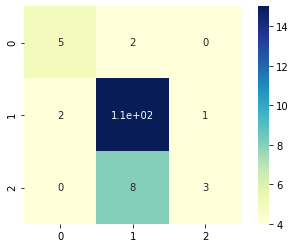

In [65]:
conf_mat = sns.heatmap(confusion_mat, square=True, vmax= 15, vmin=4, annot=True, cmap='YlGnBu')

Now we can succesfully predict whether a person will be isolated, released or have chances of dying due to virus.<br>
This model can be useful to predict how much care a patient requires along with chances of whether patient can be released in futire or not.
<br>
This is not at all meant for production but rather a simple model to beat hurestic of whether an individual can be released or not.